#**Lesson 2:**

##**Creating our DS from Google Images**

Let's create our own dataset from Google Images. Today will clasify Grizlly Bears, Teddy Bears and Black Bears.

In order to download such data we need to do the following:



1. Search on Google Images whatever we want.
2. Scroll down up to when we think we have enough images.
3. We should get a list fom all the urls by pressing Ctrl + Shift + J in Windos and then pasting:
```
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```
in the Javascript console that pops up.




##**Create directory and upload urls file into your server**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Let's choose an appropriate name for our labeled images.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
folders = ['black', 'teddys', 'grizzly']
files = ['black.txt', 'teddys.txt', 'grizzly.txt']

In [0]:
PATH = 'gdrive/My\ Drive/Colab\ Notebooks/L2DL/data/'
PATH = PATH.replace("\\", "")
path = Path(PATH)

Let's create the respective folders and download such images.

In [0]:
for i in range(len(folders)):
  dest = path/folders[i]
  dest.mkdir(parents=True, exist_ok=True)
  download_images(path/files[i], dest, max_pics=200)

Error https://www.washingtonpost.com/wp-apps/imrs.php?src=https://arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/XK6YBT5GSE2LROLN3FO4WRK5JI.jpg&w=767 HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=4)
Error https://www.pineandlakes.com/incoming/article2973295.ece/alternates/BASE_LANDSCAPE/4205960%2B0512_pl-bear_looking.jpg HTTPSConnectionPool(host='www.pineandlakes.com', port=443): Read timed out. (read timeout=4)
Error https://backendimage.taiwannews.com.tw/photos/2019/06/10/1560153415-5cfe0d475fe0a.jpg HTTPSConnectionPool(host='backendimage.taiwannews.com.tw', port=443): Max retries exceeded with url: /photos/2019/06/10/1560153415-5cfe0d475fe0a.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
Error https://wesa.org/sites/wesa/files/styles/medium/public/201806/black_bears.jpg HTTPSConnectionPool(host='wesa.org', port=443): Max retries exceeded with url: /sites/we

In [0]:
classes = folders.copy()

Let's verify that the images files are not corrupted for some reason.

In [0]:
for c in classes:
  print(c)
  verify_images(path/c, delete=True, max_workers=8)

In [0]:
for c in classes:
  print(c)
  print(len((path/c).ls()))

black
177
teddys
181
grizzly
181


##**View Our Data**

Something we should notice is that we usually want a training set, validation set and sometimes a test set. In this case since we downloaded the images from google directly then we don't actually have that so we just add a valid_pct that crates a validation set randomly with such percentage.

Also train is '.' since that is our current folder. (The default value for this is 'train'.

We should also note that we are normalizing with the imagenet_stats.

We use a random seed since we would like to replicate this validation set every time we run it. 

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['black', 'grizzly', 'teddys']

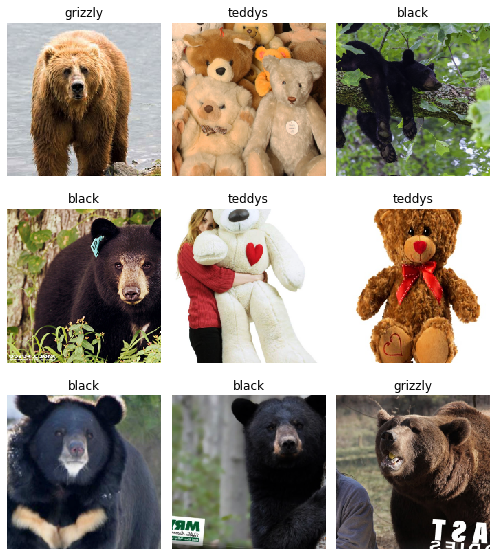

In [0]:
data.show_batch(rows=3, figsize=(7, 8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds) 

(['black', 'grizzly', 'teddys'], 3, 427, 106)

##**Train our Model**

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

Let's check the learing rate:

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

When looking at the learning reate finder above we try to look for the strongest downward slope that's sticking for quite a while. Usualy we can try any slope but if we follow such advice then most likely that would be the best one.

Here we pick 3e-5 and 3e-4. It's good that the second one is ~ 10x bigger than the other one.

In [0]:
learn.fit_one_cycle(2, max_lr=slize(3e-5, 3e-4))

In [0]:
learn.save('stage-2')

##**Interpretation:**

In [0]:
learn.load('stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_confusion_matrix()

##**Cleanining Up**

We've got very good results already but since we haven't seen all our data ye tthere may be some outliars of images that aren't actually what we think they are. After all we obtained our data set from Google Images. So, how do we fix that? We wan't to clean it up.

The way we will solve this is by taking a look at the top losses.

If we think about it it's very unlikely that mislabeled data will be predicted correctly and with high confidence. Hence we should focuss on the ones the model is saying is not confidence enough or it was confident enough but it was wrong about it because this may be thing that are misslabeled.

In [0]:
from fastai.widgets import *

Let's get all our data combining validation an training set.

In [0]:
if (path/'cleaned.csv').exists():
  print('Cleaned data already exists')
  db = (ImageList.from_csv(path, 'cleaned.csv', folder-'.').split_none().label_from_df().transform(get_transforms(), size=224).databunch())
else:
  print('Cleaned data doesnt exist yet')
  db = (ImageList.from_folder(path).split_none().label_from_folder().transform(get_transforms(), size=224).databunch())

Now let's crete  anew learner to use our new databunch with all the images:

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metric=error_rate)
learn_cln.load('stage-2')
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Now that we have our data set and our indexes we will call the ImageCleaner:

In [0]:
ImageCleaner(ds, idxs, path)

Now we have our set cleaned. Now we can reload the data now from the generated csv file and retrain our model to see if it improves.

##**Putting our model into production op1 (a bit large):**


In [0]:
data.classes

We probably want to use CPU for inference, exept at a massive scale. If you don't have a GPU that happens automatically you can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

In [0]:
img = open_image(path/'black'/'00000021.jpg')
img

As long as we save the weights from our stage we can mount such thing in our server.

In [0]:
classes = ['black', 'grizzly', 'teddys']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('stage-2')

Let's check our prediction

In [0]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

##**Putting our model into production op2:**

We can export the content of our learner object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working with all the data from our model:(the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [0]:
img = open_image(path/'black'/'00000021.jpg')
img

We can create our learner in production environmet like this:

In [0]:
learn = load_learner(path)

In [0]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

##**How a Production Query receptor may look:**

```
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```



##**Problems and Hyperparameters**

* Most of the time things will train fine with defaults.
* There's not much you really need to tune (despite what we've heard)
* Most likely problems are due to:
 * Learning rate
 * Number of epoch

###**Learning rate (LR) too high**

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(1, max_lr=0.5)

As we can see above our validation loss get really high. Which ideally is under 1.

If our validation loss is something very big this means our learning rate is too high, we should make it lower.

###**Learning rate (LR) too low**

In [0]:
learn = create_cnn(data, models.resnet_34, metric = error_rate)

In [0]:
learn.fit_one_cycle(5, max_lt = 1e-5)

As we can see above our error rate gets better but extremely slowly.

Lets plot the losses which pots the validation and training loss:

In [0]:
learn.recorder.plot_losses()

Another factor as we can see is that our trianing loss is hihger than our validation loss since this means we haven't fit it enough (which may be also due to the epoch).

###**Too few epochs**

In [0]:
learn = create_cnn(data, models.resnet34, metric=error_rate)

In [0]:
learn.fit_one_cycle(1)

As we can see our error rate is better than random but our train loss is much higher than our validation loss.

###**Too many epochs**

This is the thing that causes overfitting.
Despite what we've heard is very rare to overfit with deep learing.

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.9, bs=32, ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
learn = create_cnn(data, models.resnet50, metric=error_rate, ps=0, wd=0)
learn.unfreeze()

In [0]:
learn.fit_one_cycle(40, slice(1e-6, 1e-4))

And here it's just overfitting at the end. One very important thing that tells us that we are overfitting is if our error rate improves then gets worse as the epochs go.
Many say that if our training loss is lower than our validation loss we are overfiting but that's not true. **Every correctly trained model has a train loss lower than validation loss** that's a sign something is right.

There are some other details that might go wrong but that's not very usual. We'll learn about those later.

##**Basic rule of thumb with learners and learning rates:**



```
learn.fit_one_cycle(4, 3e-3) # fine tunning
learn.unfreeze()
learn.fit_one_cycle(4, slice(xxx, 3e-4)
```
1. What we do first is set up the regular fine tunning trainined
2. Then we unfreeze the model
3. Then we are missing one number in the slice and we get that number from the learing rate finder and it's the bit where we have the strongest slope.

##**Understanding concepts creating our own SGD**

A picture is actually a bunch of numbers. Images are usually a rank 3 tensor. whihc contains a pixel matrix with 3 values inside every pixel (RGB).

Usually the output from our network looks like this:
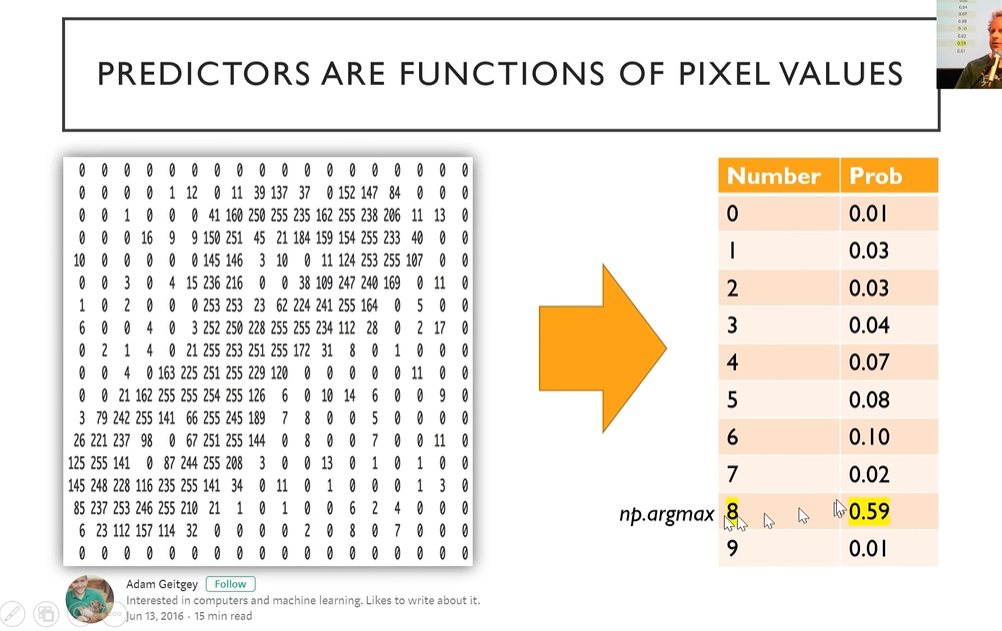

What the above image is telling us is what's the probabiliy of the input image of being each of those numbers. What we usually do is just take the one with the maximum image and return it's index.

###**Understanding Gradient Descent**

So let's say we are given a very simple linear equation:


```
y = ax + b =
y + a1*X1 + a2*X2

where X1 is our variable and X2 is always 1
```

The last representation helps us with introducing the linear algebra which makes easier our lives when computing a gradient.

Now let's say we have a graph that looks like this:


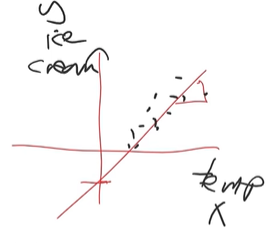

So in this case we are trying to fit our linear model:

```
a1*X1 + a2*X2
```
to such graph.



How to do this?

Well here's were we introduce a bit of linear algebra.

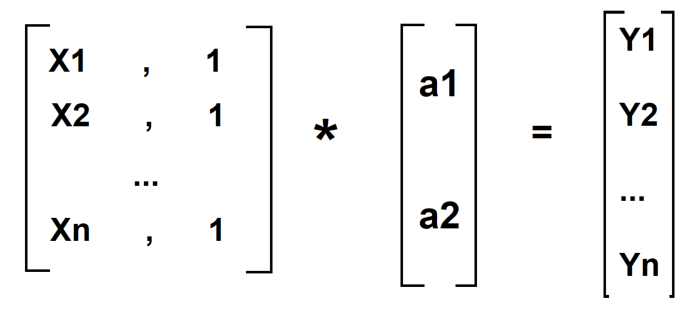

We should find 2 coefficients **a1** and **a2** that fit the best possible all the dots we find in our graph.

As we can imagine those dots follow the format:

X1, Y1

X2, Y2

...

Xn, Yn

Let's create our X matrix:

In [0]:
%matplotlib inline

In [0]:
n = 100

In [0]:
x = torch.ones(n, 2)
x[:, 0].uniform_(-1, 1)
x[:5]

tensor([[ 0.3042,  1.0000],
        [-0.2696,  1.0000],
        [ 0.3108,  1.0000],
        [-0.4466,  1.0000],
        [ 0.5728,  1.0000]])

In [0]:
a = tensor(3., 2.)
a

tensor([3., 2.])

Let's generate the data from the graph:

In [0]:
y = x@a + torch.rand(n)

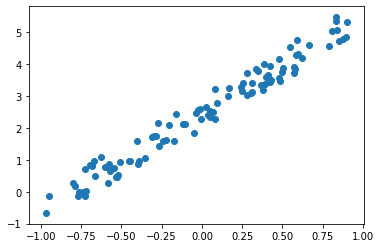

In [0]:
plt.scatter(x[:, 0], y)

Let's make our SGD but first let's choose an error function, in this case: let it be the **mean squared error**:

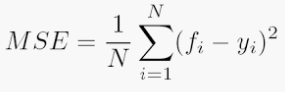

In [0]:
#y_hat -> predictions
#y -> actual values
def mse(y_hat, y): return ((y_hat-y)**2).mean()

So our objective is basically to find **a1**(m) and **a2**(b) such that we minimize the loss function. let's start with -1, 1

In [0]:
a = tensor(-1., 1.)

In [0]:
y_hat = x@a

In [0]:
mse(y_hat, y)

tensor(6.4954)

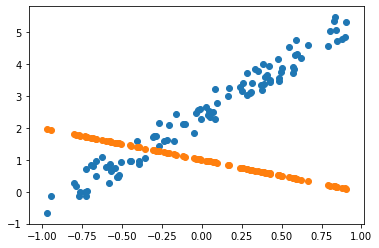

In [0]:
plt.scatter(x[:, 0], y)
plt.scatter(x[:, 0], y_hat)

Let's make this guess better by using calculus by and seeing where we have to move **a1** and **a2** for our guess to improve.

In [0]:
a = nn.Parameter(a)
a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [0]:
def update(lr):
  y_hat = x@a
  loss = mse(y, y_hat)
  if t % 10 == 0: print(loss)
  loss.backward()
  with torch.no_grad():
    a.sub_(lr*a.grad)
    a.grad.zero_()

In [0]:
lr = 1e-1
for t in range(100): update(lr)

tensor(6.4954, grad_fn=<MeanBackward0>)
tensor(1.5230, grad_fn=<MeanBackward0>)
tensor(0.5583, grad_fn=<MeanBackward0>)
tensor(0.2424, grad_fn=<MeanBackward0>)
tensor(0.1363, grad_fn=<MeanBackward0>)
tensor(0.1006, grad_fn=<MeanBackward0>)
tensor(0.0887, grad_fn=<MeanBackward0>)
tensor(0.0847, grad_fn=<MeanBackward0>)
tensor(0.0833, grad_fn=<MeanBackward0>)
tensor(0.0828, grad_fn=<MeanBackward0>)


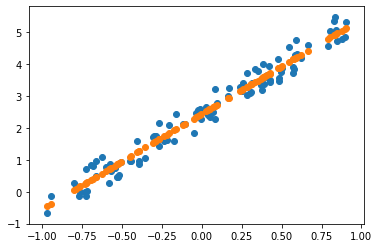

In [0]:
plt.scatter(x[:, 0], y)
plt.scatter(x[:, 0], x@a)

So there's 3 basic concepts we should now from this:

* What we just this is GD and the main difference from it and SGD is that SGD uses mini batches for its computations.

* **learning_rate:** The scalar that's multiplied by our current gradient to move that way.
* **epoch:** One complete run through all our images.

### **How error rate is calculated?**

In [0]:
error_rate??

In [0]:
accuracy??

**Metrics are always applied to the validation set in learners.**

The error rate is the percentage of failed predictions in the validation set.